In [1]:
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

import subprocess
from matplotlib.animation import FuncAnimation
import matplotlib.patches as patches
from matplotlib.colors import ListedColormap
from scipy.io import loadmat
import natsort, pathlib
import os
import glob

In [2]:
colormap_data = loadmat('../cold2hot.mat')
cold2hot = ListedColormap(colormap_data['colormap'])
hot2cold = ListedColormap(colormap_data['colormap'][::-1])

In [75]:
path = os.path.abspath('../../0_MOOSE_Input_Files/Heat_Sources/')

In [4]:
model_path_pf_temp = path+'/ML_Data/Bessel/TDB/exodus/Au-Au.e'
model_path_temp_only = path+'/ML_Data/Bessel/temp_only/exodus/Au-Au.e'

## PF with temperature data

In [5]:
df1 = pd.read_csv(path+'/ML_Data/Bessel/TDB/exodus/Au-Au.csv',  encoding='utf-8')
real_time = np.array(df1['time'])
df1.head()

,time,area_h1,temp_avg,temp_max,temp_min
0,0.000000,2680.208333,0.000000,0.000000,0.000000
1,0.003750,2674.077210,341.996976,583.458769,300.004667
2,0.007500,2667.919912,357.081540,660.835527,300.007165
3,0.011250,2661.957731,374.577500,758.600889,300.009259
4,0.013125,2659.079913,384.029463,811.760383,300.010328


In [88]:
model = netCDF4.Dataset(model_path_pf_temp)

In [89]:
names = model.variables["name_nod_var"]
names.set_auto_mask(False)
param_in_exodus = [b"".join(c).decode("latin1") for c in names[:]]
print(param_in_exodus)

['eta1', 'p', 'temp', 'vel_x', 'vel_y']


In [90]:
parameters = ['vals_nod_var1', 'vals_nod_var3',]

In [91]:
LIQ, temp = [], []

for i in range(2):
    param = model.variables[parameters[i]][:]

    X_all = model.variables['coordx'][:]
    Y_all = model.variables['coordy'][:]
    
    points = np.vstack([Y_all,X_all,param]).T
    
    column_names = ['X', 'Y'] + list(range(param.shape[0]))
    df = pd.DataFrame(points, columns=column_names)
    df = df.sort_values(by = ['X', 'Y'], ascending = [True, True], ignore_index=True)
    df_param = df.iloc[:, 2:]
    
    x_dim  = model.dimensions['num_nod_ns1'].size
    y_dim =  model.dimensions['num_nod_ns2'].size
    time_steps = model.dimensions['time_step'].size
    array_ = df_param.to_numpy().flatten().reshape(y_dim, x_dim, time_steps)
    array = np.flip(array_, axis=0)
    if i == 0:
        LIQ.append(array)
    else:
        temp.append(array)

# time = np.array(model.variables['time_whole'][:]).reshape((-1, ))
# LIQ, temp, = np.clip(LIQ[0][:,:,:], 0, 1), temp[0][:,:,:]
# FCC = 1- LIQ

In [70]:
## BHS 66;477 | GHS 52;455 | FTHS 62;469 | RHS 17;419 
t_ST = 1+2*32
time_steps = 2*417
dt = time_steps - t_ST
time = np.array(model.variables['time_whole'][:]).reshape((-1, ))[np.r_[t_ST:time_steps]]
LIQ, temp = np.where(LIQ[0] < 0.5, 0, 1)[:, :, np.r_[t_ST:time_steps]], temp[0][:, :, np.r_[t_ST:time_steps]]

X_, y_ = np.moveaxis(temp, -1, 0), np.moveaxis(LIQ, -1, 0)
X_, y_, time = X_[1::2], y_[1::2], time[1::2]

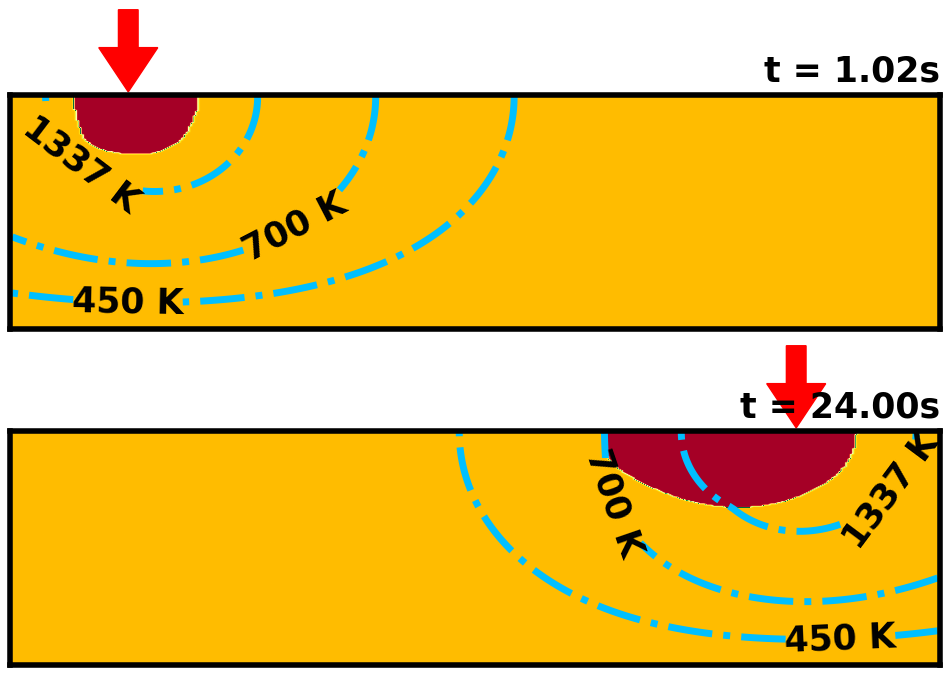

In [71]:
t_step = -1
laser_speed = 30
laser_pos = (125 + time[t_step]*laser_speed)* 401/1000  # Laser actual position in true dimension

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8), frameon=True)
cmap = plt.get_cmap('RdYlGn_r')
cmap.set_under('white', alpha=0)
hmap1 = ax1.imshow(y_[0], cmap=cmap, vmin=0.5, vmax=1.0, aspect=0.5,  interpolation='quadric')
cmap = plt.get_cmap('Wistia')
cmap.set_under('white', alpha=0) 
hmap2 = ax1.imshow(1-y_[0], cmap=cmap, vmin=0.5, vmax=1.5, aspect=0.5, interpolation='quadric')
ax1.arrow(50.125,-75, 0, 71,  width = 8.5, color='red', length_includes_head=True, clip_on=False)
ax1.set_title(f't = {time[0]:.2f}s', pad=10, loc='right', fontsize=25, weight='bold')
for label in ax1.clabel(ax1.contour(X_[0], levels=[450, 700, 1337], colors='deepskyblue', linewidths=5, linestyles='dashdot'), inline=True, fontsize=25, colors='k', fmt='%1.0f K'): label.set_fontweight('bold')

cmap = plt.get_cmap('RdYlGn_r')
cmap.set_under('white', alpha=0)
hmap3 = ax2.imshow(y_[t_step], cmap=cmap, vmin=0.5, vmax=1.0, aspect=0.5,  interpolation='quadric')
cmap = plt.get_cmap('Wistia')
cmap.set_under('white', alpha=0) 
hmap4 = ax2.imshow(1-y_[t_step], cmap=cmap, vmin=0.5, vmax=1.5, aspect=0.5, interpolation='quadric')
ax2.arrow(laser_pos,-75, 0, 71,  width = 8.5, color='red', length_includes_head=True, clip_on=False)
ax2.set_title(f't = {time[t_step]:.2f}s', pad=10, loc='right', fontsize=25, weight='bold')

for ax in [ax1, ax2]: ax.set_ylim(201, -1); ax.set_xlim(-1, 401); ax.tick_params(axis='both', labelcolor='black', labelsize=65, bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False); ax.spines[:].set_linewidth(4)
for label in ax2.clabel(ax2.contour(X_[t_step], levels=[450, 700, 1337], colors='deepskyblue', linewidths=5, linestyles='dashdot'), inline=True, fontsize=25, colors='k', fmt='%1.0f K'): label.set_fontweight('bold')

In [72]:
##########################################
# Saving as Numpy Files
save_path = os.path.abspath('../../1_Simulation_Results/ML_numpy_files/quant_data/pf_temp/')
np.save(save_path+'/X.npy', X_)
np.save(save_path+'/y.npy', y_)
np.save(save_path+'/time.npy', time)

## Temperature only data

In [96]:
df2 = pd.read_csv(path+'/ML_Data/Bessel/temp_only/exodus/Au-Au.csv',  encoding='utf-8')
real_time = np.array(df2['time'])
df2.head()

,time,temp_avg,temp_max,temp_min
0,0.00,0.000000,0.000000,0.000000
1,0.06,590.653083,2742.420686,300.028391
2,0.12,594.952116,2753.996854,300.031036
3,0.18,595.748790,2752.712814,300.031485
4,0.24,596.468228,2750.728553,300.031828


In [97]:
model = netCDF4.Dataset(model_path_temp_only)

In [98]:
names = model.variables["name_nod_var"]
names.set_auto_mask(False)
param_in_exodus = [b"".join(c).decode("latin1") for c in names[:]]
print(param_in_exodus)

['p', 'temp', 'vel_x', 'vel_y']


In [99]:
parameters = ['vals_nod_var2']

In [103]:
temp = []
i = 0
param = model.variables[parameters[i]][:]
X_all = model.variables['coordx'][:]
Y_all = model.variables['coordy'][:]
points = np.vstack([Y_all,X_all,param]).T
column_names = ['X', 'Y'] + list(range(param.shape[0]))
df = pd.DataFrame(points, columns=column_names)
df = df.sort_values(by = ['X', 'Y'], ascending = [True, True], ignore_index=True)
df_param = df.iloc[:, 2:]

x_dim  = model.dimensions['num_nod_ns1'].size
y_dim =  model.dimensions['num_nod_ns2'].size
time_steps = model.dimensions['time_step'].size
array_ = df_param.to_numpy().flatten().reshape(y_dim, x_dim, time_steps)
array = np.flip(array_, axis=0)
temp.append(array)

In [104]:
t_ST = 17
time_steps = 401
dt = time_steps - t_ST
time = np.array(model.variables['time_whole'][:]).reshape((-1, ))[np.r_[t_ST:time_steps]]
temp = temp[0][:, :, np.r_[t_ST:time_steps]]

X_= np.moveaxis(temp, -1, 0)

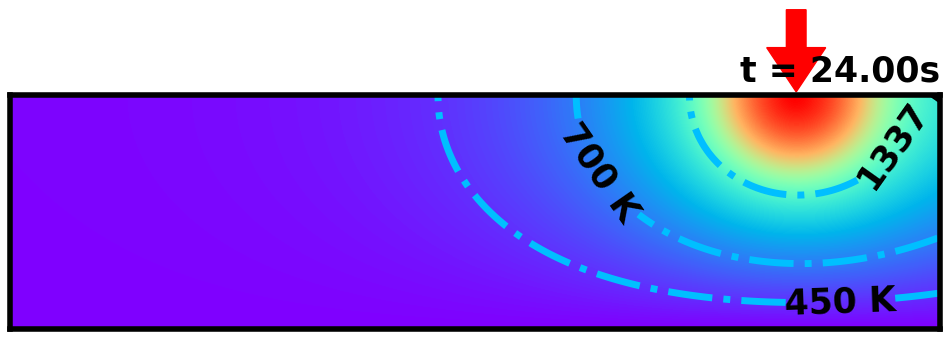

In [108]:
t_step = -1
laser_speed = 30
laser_pos = (125 + time[t_step]*laser_speed)* 401/1000  # Laser actual position in true dimension

fig, (ax1) = plt.subplots(1,1, figsize=(12,4), frameon=True)
cmap = plt.get_cmap('rainbow')
cmap.set_under('white', alpha=0)
hmap1 = ax1.imshow(X_[t_step], cmap=cmap, vmin=300,  aspect=0.5,  interpolation='quadric')
ax1.arrow(laser_pos,-75, 0, 71,  width = 8.5, color='red', length_includes_head=True, clip_on=False)
ax1.set_title(f't = {time[t_step]:.2f}s', pad=10, loc='right', fontsize=25, weight='bold')
for label in ax1.clabel(ax1.contour(X_[t_step], levels=[450, 700, 1337], colors='deepskyblue', linewidths=5, linestyles='dashdot'), inline=True, fontsize=25, colors='k', fmt='%1.0f K'): label.set_fontweight('bold')

ax1.set_ylim(201, -1); ax1.set_xlim(-1, 401); ax1.tick_params(axis='both', labelcolor='black', labelsize=65, bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False); ax1.spines[:].set_linewidth(4)


In [109]:
##########################################
# Saving as Numpy Files
path = os.path.abspath('../../1_Simulation_Results/ML_numpy_files/quant_data/temp_only/')
np.save(path+'/X.npy', X_)
np.save(path+'/time.npy', time)